Assignment 2: 

Name: 

UID: 

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: 


In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt
from PIL.ImageOps import grayscale

import skimage.transform as tf
import skimage
from scipy.sparse.linalg.isolve.lsmr import norm
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from sklearn import preprocessing
from matplotlib.pyplot import figure
from PIL.ImageOps import grayscale
from google.colab.patches import cv2_imshow

%matplotlib inline

# Part 1: A Feature Tracker (50 Points)

## Overview

In the problem, you will implement a corner detector and feature tracker that track features from the image sequence hotel. Since this is a two part problem, we have included precomputed intermediate results in the *Data* section in case you’re unable to complete any portion.

<img src="https://drive.google.com/uc?id=1sBtKpU2mYEPZ9c2Cvw-DBuLBPK2gYwC-" width="700"/>

**Note:**  Do not use existing keypoint
detectors, trackers, or structure from motion code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
!unzip "/content/part1_images.zip" -d "/content/"
!gdown 1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym
# Load Initial Key Points
data = loadmat('/content/initial_keypoints.mat')
X0 = data['Xo']
Y0 = data['Yo']

Downloading...
From: https://drive.google.com/uc?id=1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
To: /content/part1_images.zip
100% 5.10M/5.10M [00:00<00:00, 138MB/s]
Archive:  /content/part1_images.zip
   creating: /content/part1_images/
  inflating: /content/part1_images/hotel.seq41.png  
  inflating: /content/part1_images/hotel.seq40.png  
  inflating: /content/part1_images/hotel.seq42.png  
  inflating: /content/part1_images/hotel.seq43.png  
  inflating: /content/part1_images/hotel.seq47.png  
  inflating: /content/part1_images/hotel.seq46.png  
  inflating: /content/part1_images/hotel.seq50.png  
  inflating: /content/part1_images/hotel.seq44.png  
  inflating: /content/part1_images/hotel.seq8.png  
  inflating: /content/part1_images/hotel.seq9.png  
  inflating: /content/part1_images/hotel.seq45.png  
  inflating: /content/part1_images/hotel.seq36.png  
  inflating: /content/part1_images/hotel.seq22.png  
  inflating: /content/part1_images/hotel.seq23.png  
  inflating: /content/part1_imag

## Helper Functions

In [ ]:
def readImages(folder, num_images):
  arr_images = []
  for i in range(num_images):
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png'))
  return np.array(arr_images, dtype=np.float32)

def trackPoints(pt_x, pt_y, im, ws):
  '''
  Tracking initial points (pt_x, pt_y) across the image sequence
  Outputs:
    track_x: [Number of keypoints] x [2]
    track_y: [Number of keypoints] x [2]
  '''
  N = np.prod(pt_x.shape)
  nim = len(im)
  track_x = np.zeros((N, nim))
  track_y = np.zeros((N, nim))
  track_x[:,0] = pt_x
  track_y[:,0] = pt_y

  for t in range(nim-1):
    track_x[:, t+1], track_y[:, t+1] = getNextPoints(track_x[:, t], track_y[:, t], im[t,:,:], im[t+1,:,:], ws)

  return track_x, track_y

def gaussian_2D_filter(size, cutoff_frequency):
  # YOUR CODE HERE
  _1D_filter = cv2.getGaussianKernel(size[0], sigma=cutoff_frequency)
  _2D_filter = np.multiply(_1D_filter.T, _1D_filter)

  return _2D_filter

def imgfilter(image, filter):
  # YOUR CODE HERE

  # check if RGB or grayscale image
  if len(image.shape) == 3:
    filtered_image = np.stack((convolve(image[:, :, 0], filter), convolve(image[:, :, 1], filter), convolve(image[:, :, 2], filter)), axis=-1)
  else:
    filtered_image = convolve(image, filter)

  return filtered_image

def normalize(img):
    ''' Function to normalize an input array to 0-1 '''
    img_min = img.min()
    img_max = img.max()
    return (img.astype(np.float32) - img_min) / (img_max - img_min)

def plot_images(imgs):
  _, axs = plt.subplots(1, len(imgs), figsize=(20, 20))
  axs = axs.flatten()
  for img, ax in zip(imgs, axs):
      if len(img.shape) == 3: 
        ax.imshow(img)
      else:
        ax.imshow(img, cmap="gray")
  plt.show()

def nonMaximalSupress(image,NHoodSize):
    dX, dY = NHoodSize
    M, N = image.shape
    image_copy = np.zeros_like(image)
    for x in range(0,M-dX+1):
        for y in range(0,N-dY+1):
            window = image[x:x+dX, y:y+dY]
            if np.sum(window)==0:
                localMax=0
            else:
                localMax = np.max(window)

            # if the center is max keep it, else make it zero
            if window[2, 2] == localMax:
              image_copy[x+2, y+2] = localMax

    return image_copy

# read all 51 sequences of images
folder = '/content/part1_images/'
im = readImages(folder, 51) 

## 1.1 Keypoint Selection (15 pts)

For the first frame, use the second moment matrix to locate strong corners to use as keypoints.
These points will be tracked throughout the sequence in the second part of the problem. Choose a proper threshold so that edges and noisy patches are ignored. Do local non-maxima suppression over a 5x5 window centered at each point.
This should give several hundred good points to track.

### Code (5 pts)

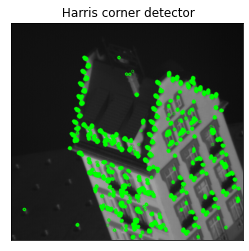

In [ ]:
from matplotlib import pyplot as plt
import os
from os import listdir


def get_keypoint(img_path,window_size,k,threshold):

    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    img_gaussian = cv2.GaussianBlur(gray,(3,3),0)    
    height = img.shape[0]  
    width = img.shape[1]    
    matrix_R = np.zeros((height,width))
    
    #Calculate the x e y image derivatives 
    dx = cv2.Sobel(img_gaussian, cv2.CV_64F, 1, 0, ksize=5)
    dy = cv2.Sobel(img_gaussian, cv2.CV_64F, 0, 1, ksize=5)
    # dy, dx = np.gradient(gray)

    # Calculate product and second derivatives 
    dx2=np.square(dx)
    dy2=np.square(dy)
    dxy=dx*dy

    offset = int( window_size / 2 )
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            Sx2 = np.sum(dx2[y-offset:y+1+offset, x-offset:x+1+offset])
            Sy2 = np.sum(dy2[y-offset:y+1+offset, x-offset:x+1+offset])
            Sxy = np.sum(dxy[y-offset:y+1+offset, x-offset:x+1+offset])
            H = np.array([[Sx2,Sxy],[Sxy,Sy2]])
            det=np.linalg.det(H)
            tr=np.matrix.trace(H)
            R=det-k*(tr**2)
            matrix_R[y-offset, x-offset]=R
    
    #  Thresholding
    cv2.normalize(matrix_R, matrix_R, 0, 1, cv2.NORM_MINMAX)
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            value=matrix_R[y, x]
            if value>threshold:
                cv2.circle(img,(x,y),3,(0,255,0))
                
    
    plt.figure(" Harris corner detector")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title(" Harris corner detector")
    plt.xticks([]), plt.yticks([])
    plt.savefig('My_harris_detector-thresh_%s.png'%(threshold), bbox_inches='tight')
    plt.show()

get_keypoint("/content/part1_images/hotel.seq0.png", 5, 0.04, 0.30)

### Write-up (10 pts)


*   (5 pts) Explain your implementation of getKeypoints()
*   (5 pts) Display the first frame of the sequence overlaid with the detected keypoints. Ensure that they are clearly visible (plot with `color='g' and linewidths=3`)



**Include your write-up here**
In order to implementation of getkeypoints() first I calculate image x and y derivatives.Derivate again the previous values to obtain the second derivative; we can use sobel()  function to compute the second derivatives of the images.
For each pixel, we sum the last step obtained derivatives. Here we are making a 1 pixel sift of the windows over the image;For each pixel and using the sums of the previous step, that define H matrix therefore we calculate the response of the detector. We use a threshold value in order to exclude some of the detections. we can archive the detection of the majority of the corners of the hotel sequences, which can be adjusted by changing the threshold value.

## 1.2 Feature Tracking (35 pts)

Apply the Kanade-Lucas-Tomasi tracking procedure to track the keypoints found in part 1.1 (or the given keypoints in the *Data* section) throughout the hotel sequence. 

<img src="https://drive.google.com/uc?id=1dU4p4YcnXoQFnrNvleEty_4tDECkVW9Q" width="500"/>

Some keypoints will move out of the image frame over the course of the sequence. Discard any track if the predicted translation falls outside the image frame.

**Hint:**

*  From the 1st frame to the 2nd frame, use the detected keypoints at the first frame as initialization points. From the 2nd to 3rd frame, use the tracked positions at the 2nd frame as initialization. Note that the tracked keypoints in general are not at integer positions.

*  For each point, use a window size of 15 x 15.

Add codes to **plot** your tracked points overlayed in the **first sequence** and the **last sequence**. They should look similar to the second picture shown in the Overview section. 



### Code (10 pts)

In [ ]:
def getNextPoints(x, y, im1, im2, ws):
  '''
  Iterative Lucas-Kanade feature tracking
  x,  y : initialized keypoint position in im2
  ws: patch window size

  output: tracked keypoint positions in im2
  '''
  img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
  img2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

  number_of_Iteration= 4
  filter_size = number_of_Iteration*5+5
  filter = gaussian_2D_filter((filter_size, filter_size), number_of_Iteration)
  smoothed_img1 = imgfilter(img1, filter=filter)

  Ix, Iy = np.gradient(smoothed_img1)

  Ix_squared = Ix*Ix
  Ix_squared= imgfilter(Ix_squared, filter=filter)
  Iy_squared = Iy*Iy
  Iy_squared= imgfilter(Iy_squared, filter=filter)
  Ix_Iy = Ix*Iy
  Ix_Iy= imgfilter(Ix_Iy, filter=filter)

  # print(np.array([[np.sum(Ix_squared), np.sum(Ix_Iy)], [np.sum(Ix_Iy), np.sum(Iy_squared)]]))
  keypoints = np.zeros((x.shape[0], 2))
  for k, (i, j) in enumerate(zip(x, y)):
    x_prime, y_prime = i, j
    A = np.sum(cv2.getRectSubPix(Ix_squared, (31, 31), (i, j)))
    B = np.sum(cv2.getRectSubPix(Ix_Iy, (31, 31), (i, j)))
    C = np.sum(cv2.getRectSubPix(Iy_squared, (31, 31), (i, j)))

    sec_moment_matrix = np.array([[A, B], [B, C]])

    img1_interpolation = cv2.getRectSubPix(img1, (31, 31), (i, j))
    img2_interpolation = cv2.getRectSubPix(img2, (31, 31), (i, j))

    It = img2_interpolation - img1_interpolation

    Ix_It = cv2.getRectSubPix(Ix, (31, 31), (i, j))*It
    Iy_It = cv2.getRectSubPix(Iy, (31, 31), (i, j))*It

    b = -np.array([[np.sum(Ix_It)], [np.sum(Iy_It)]])

    displacement,*_ = np.linalg.lstsq(sec_moment_matrix, b)
    x_prime += displacement[0, 0]
    y_prime += displacement[1, 0]

    keypoints[k, 0] = x_prime
    keypoints[k, 1] = y_prime

  return keypoints[:,0], keypoints[:,1]

# track keypoints across the sequences, getNextPoints() is called inside the trackPoints() function
ws = 7
tracked_pts = trackPoints(pt_x=X0[:,0], pt_y=Y0[:,0], im=im, ws=ws)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


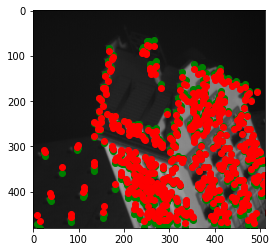

In [ ]:
plt.scatter(tracked_pts[0][ :, 8], tracked_pts[1][ :, 0], color='green')
plt.scatter(tracked_pts[0][ :, 8], tracked_pts[1][ :, 10], color='red')
plt.imshow(im[0].astype(np.uint8))

### Write-up (25 pts)

*   (5 pts) For all the keypoints, display (1) the keypoints at the first frame (as green) and (2) the tracked keypoints at the second frame (as red) on the first frame of the sequence.
*   (10 pts) For 20 random keypoints, draw the 2D path over the sequence of frames. That is, plot the progression of image coordinates for each of the 20 keypoints. Plot each of the paths on the same figure, overlaid on the first frame of the sequence.
*   (10 pts) On top of the first frame, plot the points which have moved out of frame at some point along the sequence.





**Include your write-up here**
1. In the above code I dispalyed the keypoints at the frame(as green) and I also tracked keypoints at the second frame(as red) on the first frame of the sequence. 
2. Please see above result that plot 2D path.

# Part 2: Shape Alignment (30 Points)

## Overview
In this problem, you will write a function that aligns two sets of points using global image transformation (similarity, affine, or perspective) and returns $T$  where $T$ is a transformation that maps non-zero points in $im1$ to non-zero points in $im2$. You may choose the alignment algorithm and the type of (global) transformation (e.g., rigid Euclidean, affine, perspective).


<img src="https://drive.google.com/uc?id=1PnWIy9ZdP9SGkmGNtFCJ-JzKLwmW-qaN" width="1000"/>

Test your code on the 25 image pairs provided in the supplementary material. We have included functions 
**(will check) evalAlignmentAll and displayAlignment to help with evaluation and display**.




## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
!unzip "/content/part2_images.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
To: /content/part2_images.zip
100% 78.4k/78.4k [00:00<00:00, 69.8MB/s]
Archive:  /content/part2_images.zip
   creating: /content/part2_images/
 extracting: /content/part2_images/Bone_1.png  
 extracting: /content/part2_images/elephant_1.png  
 extracting: /content/part2_images/brick_2.png  
 extracting: /content/part2_images/Heart_2.png  
 extracting: /content/part2_images/Bone_2.png  
  inflating: /content/part2_images/elephant_2.png  
 extracting: /content/part2_images/brick_1.png  
 extracting: /content/part2_images/Heart_1.png  
  inflating: /content/part2_images/device7_1.png  
  inflating: /content/part2_images/device7_2.png  
 extracting: /content/part2_images/fork_2.png  
 extracting: /content/part2_images/turtle_2.png  
  inflating: /content/part2_images/fork_1.png  
 extracting: /content/part2_images/turtle_1.png  
 extracting: /content/part2_images/butterfly_2.png  
 extracting: /content/pa

## Helper Functions

In [ ]:
def evalAlignment(aligned1, im2):
  '''
  Computes the error of the aligned image (aligned1) and im2, as the
  average of the average minimum distance of a point in aligned1 to a point in im2
  and the average minimum distance of a point in im2 to aligned1.
  '''
  d2 = ndimage.distance_transform_edt(1-im2) #distance transform
  err1 = np.mean(np.mean(d2[aligned1 > 0]))
  d1 = ndimage.distance_transform_edt(1-aligned1);
  err2 = np.mean(np.mean(d2[im2 > 0]))
  err = (err1+err2)/2;
  return err

def displayAlignment(im1, im2, aligned1, thick=False):
  '''
  Displays the alignment of im1 to im2
     im1: first input image to alignment algorithm (im1(y, x)=1 if (y, x) 
      is an original point in the first image)
     im2: second input image to alignment algorithm
     aligned1: new1(y, x) = 1 iff (y, x) is a rounded transformed point from the first time 
     thick: true if a line should be thickened for display
  ''' 
  if thick:
    # for thick lines (looks better for final display)
    dispim = np.concatenate((cv2.dilate(im1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(aligned1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(im2.astype('uint8'), np.ones((3,3), np.uint8), iterations=1)), axis=-1)
  else:
    # for thin lines (faster)
    dispim = np.concatenate((im1, aligned1, im2), axis = -1)
  return dispim
  

## Code (15 pts)

In [ ]:
from numpy.core.memmap import uint8
def shape_alignment(im1, im2):

  # mapping the non-zero points in both images
  contours1, _ = cv2.findContours(im1, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  contours2, _ = cv2.findContours(im2, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  contours1= np.concatenate(contours1)
  contours2= np.concatenate(contours2)

  def transformed_contours(contours1, contours2):
    nearest_neighbor_ids = []
    for point in contours2:
      distances = np.linalg.norm(contours1 - point, axis=2)
      k = 1
      nearest_neighbor_ids.append(distances.squeeze().argsort()[0])
    

    A, b = [], []
    for i, point in enumerate(contours2.squeeze()):
      x, y = point
      x_prime, y_prime = contours2[nearest_neighbor_ids[i]].squeeze()
      A.append([x, y, 0, 0, 1, 0])
      A.append([0, 0, x, y, 0, 1])
      b.append(x_prime)
      b.append(y_prime)

    A = np.array(A)
    b = np.array(b)

    

    transformation,*_ = np.linalg.lstsq(A, b)

    M = np.array([[transformation[0], transformation[1]], [transformation[2], transformation[3]]])
    T_matrix = np.array([[transformation[4]], [transformation[5]]])

    transformed_points = []
    for point in contours2:
      
      transformed_points.append(M@point.T + T_matrix)
    
    return np.array(transformed_points)

  iterative_transform = contours2
  for i in range(50):
    iterative_transform = transformed_contours(iterative_transform, contours2).reshape(iterative_transform.shape[0], 1, 2)
    


  A, b = [], []
  for i, point in enumerate(contours2.squeeze()):
    x, y = point
    x_prime, y_prime = iterative_transform[i].squeeze()
    A.append([x, y, 0, 0, 1, 0])
    A.append([0, 0, x, y, 0, 1])
    b.append(x_prime)
    b.append(y_prime)

  A = np.array(A)
  b = np.array(b)
  

  transformation,*_ = np.linalg.lstsq(A, b)

  M = np.array([[transformation[0], transformation[1]], [transformation[2], transformation[3]]])
  T_matrix = np.array([[transformation[4]], [transformation[5]]])

  # alignment of two shape from 2 input images
  aligned_image = np.zeros_like(im1)
  for i in range(im1.shape[0]):
    for j in range(im1.shape[1]):
      point = np.array([[i], [j]])
      new_point = np.round(M@point + T_matrix).astype(np.uint32)
      if (new_point[0] >= 0 and new_point[0] < im1.shape[0]) and (new_point[1] >= 0 and new_point[1] < im1.shape[1]):
        
        aligned_image[new_point[1], new_point[0]] = im1[i, j]
      

  plot_images([im1, im2, aligned_image])
  return transformation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


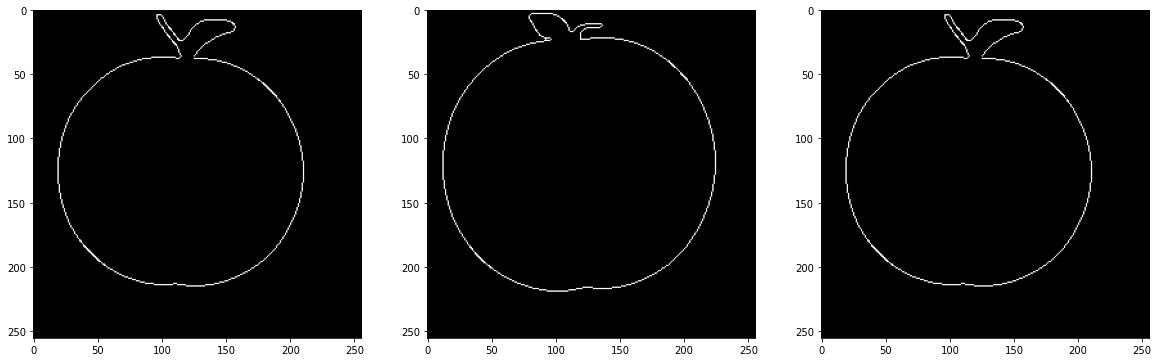

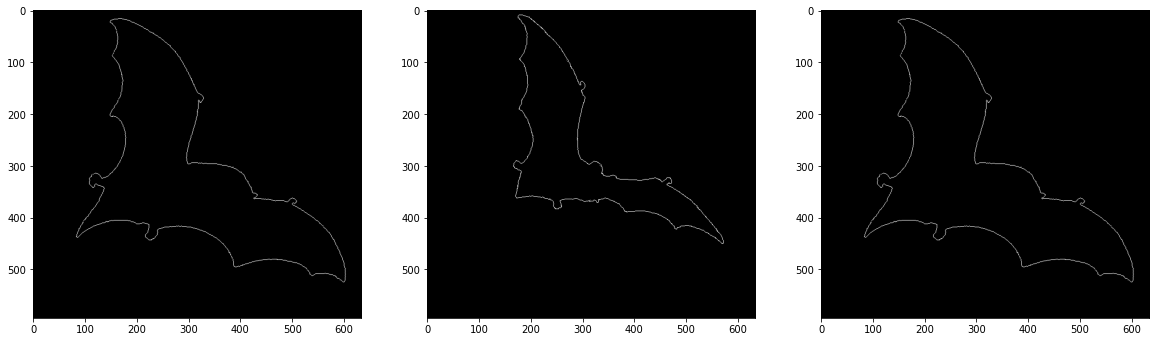

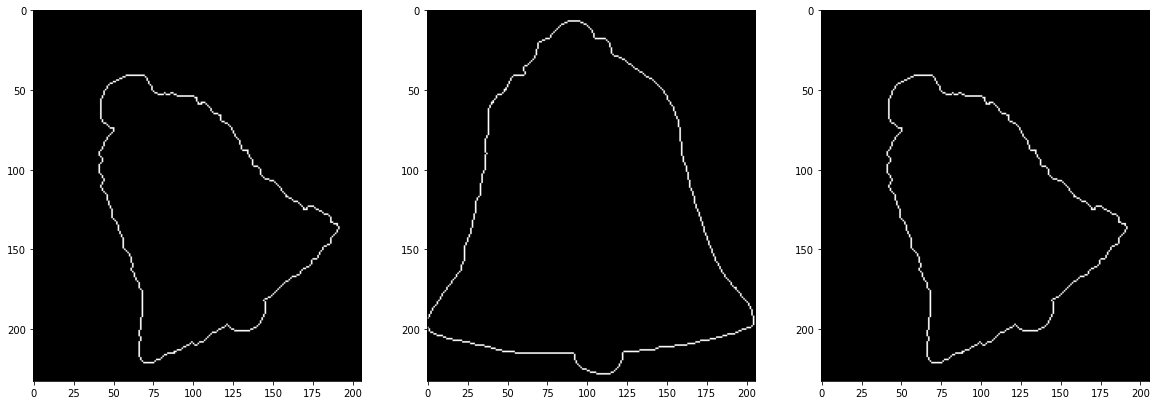

KeyboardInterrupt: ignored

In [ ]:
import time

imgPath = './part2_images/';

objList = ['apple', 'bat', 'bell', 'bird', 'Bone', 'bottle', 'brick', \
    'butterfly', 'camel', 'car', 'carriage', 'cattle', 'cellular_phone', \
    'chicken', 'children', 'device7', 'dog', 'elephant', 'face', 'fork', 'hammer', \
    'Heart', 'horse', 'jar', 'turtle']

numObj = len(objList)

# Add code to run align_shape() and display the results and the errors
# YOUR CODE HERE
def read_image(image_path):
  # YOUR CODE HERE
  image = np.array(Image.open(image_path)).astype(np.uint8)
  
  return image

for object_ in objList:
  T = shape_alignment(read_image(imgPath+f"{object_}_1.png"), read_image(imgPath+f"{object_}_2.png"))

## Write-up (15 pt)

1. (5 pts) Give a brief explanation of your algorithm, initialization, and model of the transformation.

2. (10 pts) For each result, give:
  1.   The alignment display
  2.   The final error
  3.   The runtime






**Include your write-up here**
We first read the reference image (or the template image) and the image we want to align to this template and then detect features in the two images. Although we need only 4 features to compute the transformation, typically hundreds of features are detected in the two images. Secondly, we find the matching features in the two images, sort them by goodness of match and keep only a small percentage of original matches. We finally display the good matches on the images and write the file to disk for visual inspection.  Finally the transformation can be applied to all pixels in one image to map it to the other image. This is done using the warpPerspective.

# Part 3: Object Instance Recognition (20 points)

## Overview
This problem explores the Lowe-style object instance recognition.

Implement the nearest neighbor distance ratio test using the pre-computed SIFT features SIFT_features.mat provided in the supplementary material. The Frame1, Frame2 indicate the 2D position, scales, and the orientation of the descriptors and Descriptor1, Descriptor2 are the correspondin 128-D SIFT features. Display the matches like this:

<img src="https://drive.google.com/uc?id=1mULTvHYeP5uj_vi7nwWThBHkDbv1eSue" width="1000"/>



## Data

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 10ByzpFbB-z178VGjwmCwc95wInD8vpNM # SIFT Features
!gdown 1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU # Stop sign image 1
!gdown 13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J # Stop sign image 1

Downloading...
From: https://drive.google.com/uc?id=10ByzpFbB-z178VGjwmCwc95wInD8vpNM
To: /content/SIFT_features.mat
100% 347k/347k [00:00<00:00, 84.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU
To: /content/stop1.jpg
100% 15.6k/15.6k [00:00<00:00, 20.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J
To: /content/stop2.jpg
100% 224k/224k [00:00<00:00, 87.3MB/s]


## Code (10 pts)

In [ ]:
import scipy.io
# mat = scipy.io.loadmat('file.mat')

img1 = cv2.imread('/content/stop1.jpg')
img2 = cv2.imread('/content/stop2.jpg')

## inside the sift are:
## Descriptor1, Descriptor2: SIFT features from image 1 and image 2
## Frame1, Frame2: position, scale, rotation of keypoints
data = scipy.io.loadmat('/content/SIFT_features.mat')
Frame1 = data['Frame1']
Descriptor1 = data['Descriptor1']
Frame2 = data['Frame2']
Descriptor2 = data['Descriptor2']

# YOUR CODE HERE

## matches: a 2 x N array of indices that indicates which keypoints from image
## 1 match which points in image 2
from scipy.spatial.distance import cdist
import numpy as np
## Display the matched keypoints
# YOUR CODE HERE


here 255.0 0.0 (683, 1379, 3)


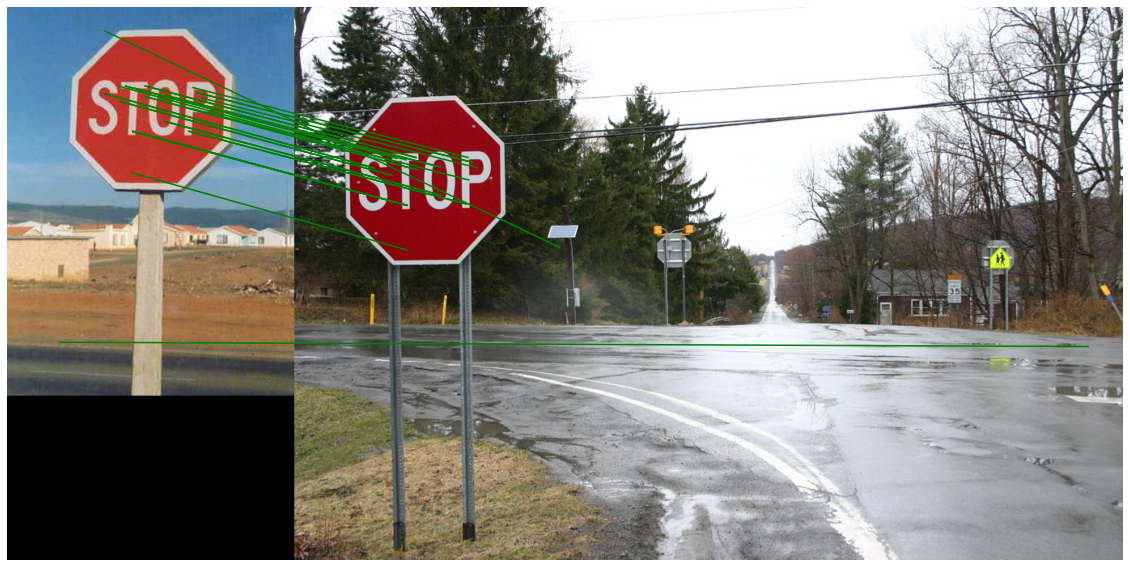

In [ ]:
def Image1_match_Image2(desc1,desc2, threshold_by_nearest_neighbor=False):
  """ For each descriptor in the first image, select its match in the second image.
  input: desc1 (descriptors for the first image), 
  desc2 (same for second image). """

  desc1 = np.array([d/np.linalg.norm(d) for d in desc1]) 
  desc2 = np.array([d/np.linalg.norm(d) for d in desc2])

  dist_ratio = 0.6
  desc1_size = desc1.shape
  matchpoint = np.zeros((desc1_size[0],1),'int') 
  desc2t = desc2.T # precompute matrix transpose 
  for i in range(desc1_size[0]):
    dotprods = np.dot(desc1[i,:],desc2t) # vector of dot products
    dotprods = 1*dotprods
    # inverse cosine and sort, return index for features in second image 
    indx = np.argsort(np.arccos(dotprods))
    if threshold_by_nearest_neighbor:
      
      matchpoint[i] = int(indx[0])
    else:
      # check if nearest neighbor has angle less than dist_ratio times 2nd
      if np.arccos(dotprods)[indx[0]] < dist_ratio * np.arccos(dotprods)[indx[1]]: 
        matchpoint[i] = int(indx[0])

  return matchpoint
def appendimages(im1,im2):
    """ Return a new image that appends the two images side-by-side. """
    
    # select the image with the fewest rows and fill in enough empty rows
    rows1 = im1.shape[0]    
    rows2 = im2.shape[0]
    
    if rows1 < rows2:
        
        im1 = np.concatenate((im1,np.zeros((rows2-rows1,im1.shape[1], im1.shape[2]))), axis=0)

    elif rows1 > rows2:
        im2 = np.concatenate((im2,np.zeros((rows1-rows2,im2.shape[1], im2.shape[2]))), axis=0)
    # if none of these cases they are equal, no filling needed.

    print("here", np.concatenate((im1,im2), axis=1).max(), np.concatenate((im1,im2), axis=1).min(), np.concatenate((im1,im2), axis=1).shape)
    return np.concatenate((im1,im2), axis=1).astype(np.int32)

def plot_matches(im1,im2,locs1,locs2,matchscores,show_below=True):
    """ Show a figure with lines joining the accepted matches
        input: im1,im2 (images as arrays), locs1,locs2 (location of features), 
        matchscores (as output from 'match'), show_below (if images should be shown below). """
    
    im3 = appendimages(im1,im2)
    if show_below:
        im3 = np.vstack((im3,im3))
    
    # show image
    plt.imshow(im3)
    
    # draw lines for matches
    cols1 = im1.shape[1]
    for i,m in enumerate(matchscores):
        if m>0:
            plt.plot([locs1[i][0],locs2[m[0]][0]+cols1],[locs1[i][1],locs2[m[0]][1]],'g')
    plt.axis('off')
matchpoint = Image1_match_Image2(Descriptor1.T, Descriptor2.T)

img1 = '/content/stop1.jpg'
img2 = '/content/stop2.jpg'

# load images and plot
im3 = np.array(Image.open(img1))
im4 = np.array(Image.open(img2))

plt.figure(figsize=(20, 20))
plot_matches(im3,im4,Frame1.T,Frame2.T,matchpoint,show_below=False)


## Write-up (10 pts)

(5 pts) Display:

1. the matches by thresholding nearest neighbor distances.

2. the matches by thresholding the distance ratio. 

(5 pts) Describe the differences of (1) and (2).

**Your answer here**
**Matches by Thresholding nearest neighbor distance:**
Please see the above result.

**Difference between 1 and 2:**
In the process of  matching by  thresholding nearest neighbor extracted features from their descriptors from two images. In order to match two features we need to set some fixed threshold that represents the maximum distance and return all matches that satisfy this threshold. we can use the Euclidean distance metric. However, this threshold is difficult to set and can be inaccurate. Sometimes a correct match can have a larger distance than an incorrect match. A better strategy is to implement the nearest neighbor distance ratio.

First, we need to compute the distance between feature fi in image one and all the features fj in image two. We choose feature fc in image two with the minimum distance to feature fi in image of one as our closest match. We then proceed to get feature fs the feature in image two with the second closest distance to the feature fi. Then we find how much nearer our closest match fc is over our second closest match fs through the distance ratio. Finally we keep the matches with distance ratio < distance ratio threshold. The distance ratio = d(fi, fc)/d(fi, fs) can be defined as the distance computed between feature fi in image one and fc the closest match in image two. Over the distance computed between feature fi and fs, the second closest match in image two.We usually set the distance ratio threshold (ρ) to around 0.5, which means that we require our best match to be at least twice as close as our second best match to our initial features descriptor. Thus discarding our ambiguous matches and retaining the good ones.